In [1]:
using Pkg; Pkg.activate("..")
using Plots; pyplot()
using Reproduce
using FileIO
using Statistics
using ProgressMeter
data_home = "../working_data/"

Activating environment at `~/GVFN/Project.toml`


┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1273
┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1273


"../working_data/"

In [28]:
Plots.scalefontsizes(1.5)

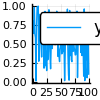

In [3]:
# Get the stupid pyplot warnings out of the way
p=plot(rand(100))
plot(p, size=(100,100))

In [16]:
# ==================
# --- DATA UTILS ---
# ==================

loadData(itm) = FileIO.load(joinpath(itm.folder_str,"results.jld2"))["results"]
TrainingNRMSE(itm) = loadData(itm)["TrainingNRMSE"]
ValidationNRMSE(itm) = loadData(itm)["ValidationNRMSE"]
TestNRMSE(itm) = loadData(itm)["TestNRMSE"]

function avgOverRuns(ic, getData::Function; runsKey = "seed")

    diff_dict = diff(ic)
    @assert length(collect(keys(diff_dict))) == 1
    @assert collect(keys(diff_dict))[1] == runsKey
    
    itms = ic.items
    res = Vector{Float64}[]
    for (itm_idx, itm) ∈ enumerate(itms)
        push!(res, getData(itm))
    end
    
    vals = zeros(length(res[1]),length(res))
    for i=1:length(res)
        vals[:,i] .= res[i]
    end
    
    μ = mean(vals,dims=2)
    σ = std(vals, dims=2, corrected=true)./sqrt(length(itms))
    
    return μ, σ
end

cfgDict(diff, arg_tuple) = Dict(Pair.(keys(diff),arg_tuple))

function get_best_setting(ic::ItemCollection, params::Dict; output_data=TrainingNRMSE)
    sub_ic = search(ic, params)
    
    # get all param settings, ignoring runs
    sub_diff = diff(sub_ic)
    delete!(sub_diff, "seed")
    
    iter = Iterators.product(values(sub_diff)...)
    best = Inf
    bestIC = nothing
    bestData = nothing
    for arg ∈ iter
        ic′ = search(sub_ic, cfgDict(sub_diff, arg))
        μ,_ = avgOverRuns(ic′, ValidationNRMSE)
        
        μ = mean(μ)
        if μ ≤ best
            best = μ
            bestIC = ic′
        end
    end
    @assert best != Inf
    
    return avgOverRuns(bestIC, output_data)
end


get_best_setting (generic function with 1 method)

In [8]:
# ==================
# --- PLOT UTILS ---
# ==================

struct PlotSpec
    ic::ItemCollection
    model::String
    key::String
    smoothing_window::Int
end

function plot_best_settings(spec::PlotSpec)
    ic = spec.ic
    d = diff(ic)
    
    model = spec.model
    τkey = spec.key
    
    p=plot()
    for τ ∈ diff(ic)[τkey]
        μ,σ = get_best_setting(ic, Dict(τkey=>τ))
        
        if spec.smoothing_window > 1
            μ, σ = begin
                
                sm = Float64[]
                smσ = Float64[]
                window=spec.smoothing_window
                for i=1:window:length(μ)-window
                    push!(sm, mean(μ[i:i+window]))
                    push!(smσ, mean(σ[i:i+window]))
                end
                sm, smσ
            end
        end
        
        xvals = collect(1:length(μ))
        plot!(p, xvals, μ, ribbon=σ; label="$(model) τ=$τ", ylabel="NRMSE", xlabel="Steps")
    end
    return p
end

plot_best_settings (generic function with 1 method)

---
# MackeyGlass
---

In [35]:
RNNSpec(ic; window=1) = PlotSpec(ic, "RNN", "rnn_tau", window)
GVFNSpec(ic; window=1) = PlotSpec(ic, "GVFN", "gvfn_tau", window)

plot_settings = [
    #:size=>(900,700),
    :ylim=>[0.15,0.7],
    :grid=>false
]

3-element Array{Pair{Symbol,Any},1}:
 :size => (900, 700) 
 :ylim => [0.15, 0.7]
 :grid => false      

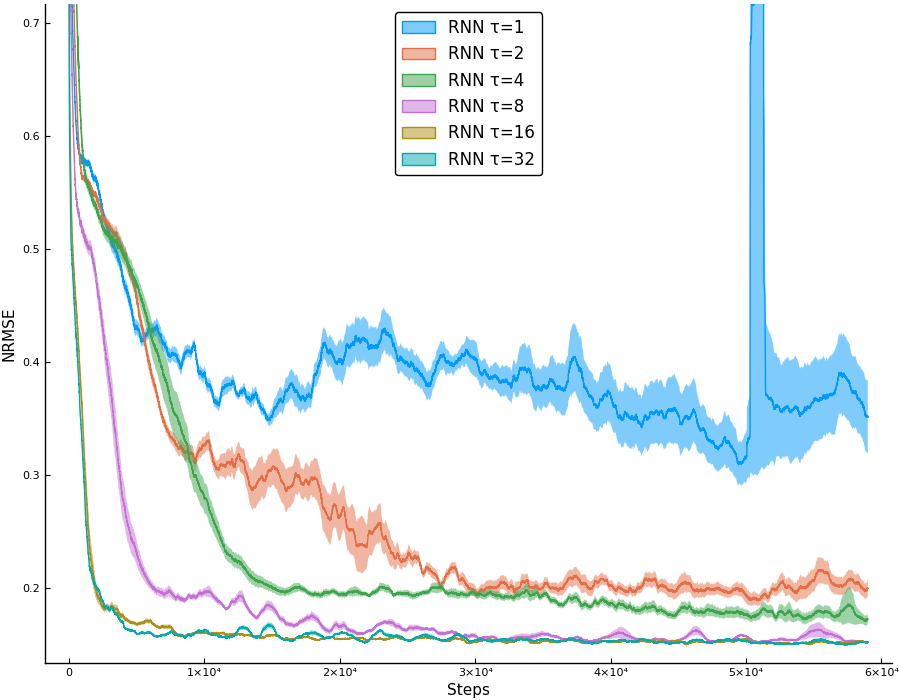

In [39]:
rnn_ic = ItemCollection(joinpath(data_home,"mackeyglass_rnn_NRMSE/data"));
p = plot_best_settings(RNNSpec(rnn_ic))
plot(p; plot_settings...)

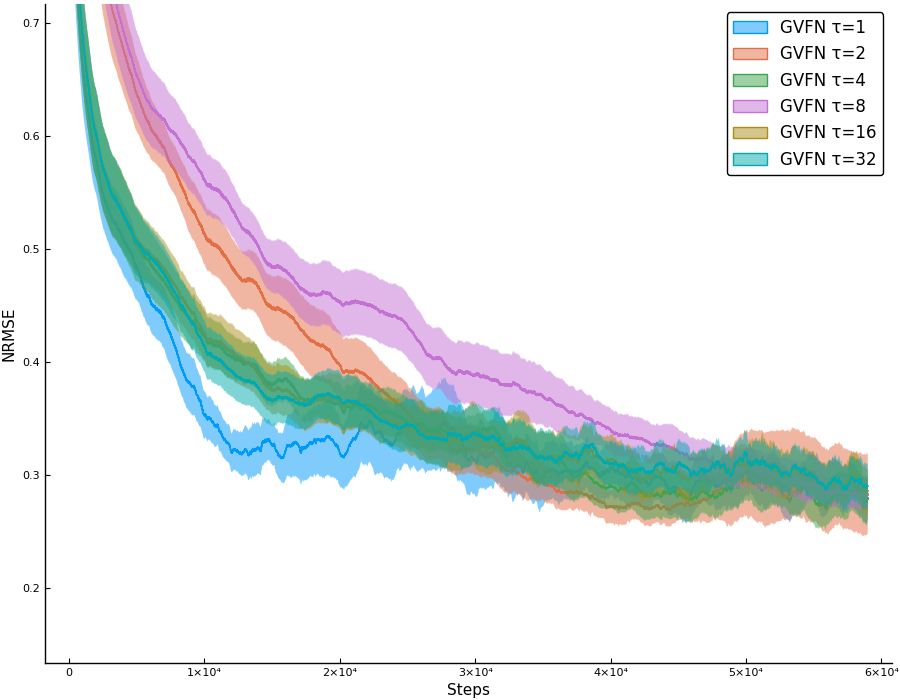

In [38]:
gvfn_ic = ItemCollection(joinpath(data_home,"mackeyglass_gvfn_relu_NRMSE/data"));
p = plot_best_settings(GVFNSpec(gvfn_ic))
plot(p; plot_settings...)

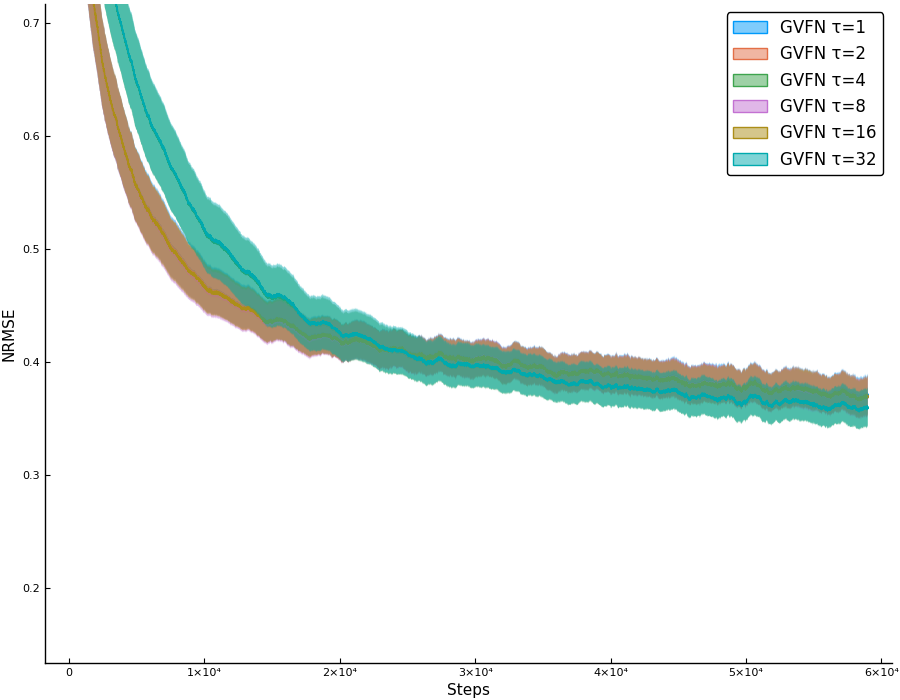

In [40]:
gvfn_ic = ItemCollection(joinpath(data_home,"mackeyglass_gvfn_relu_adam_NRMSE/data"));
p = plot_best_settings(GVFNSpec(gvfn_ic))
plot(p; plot_settings...)

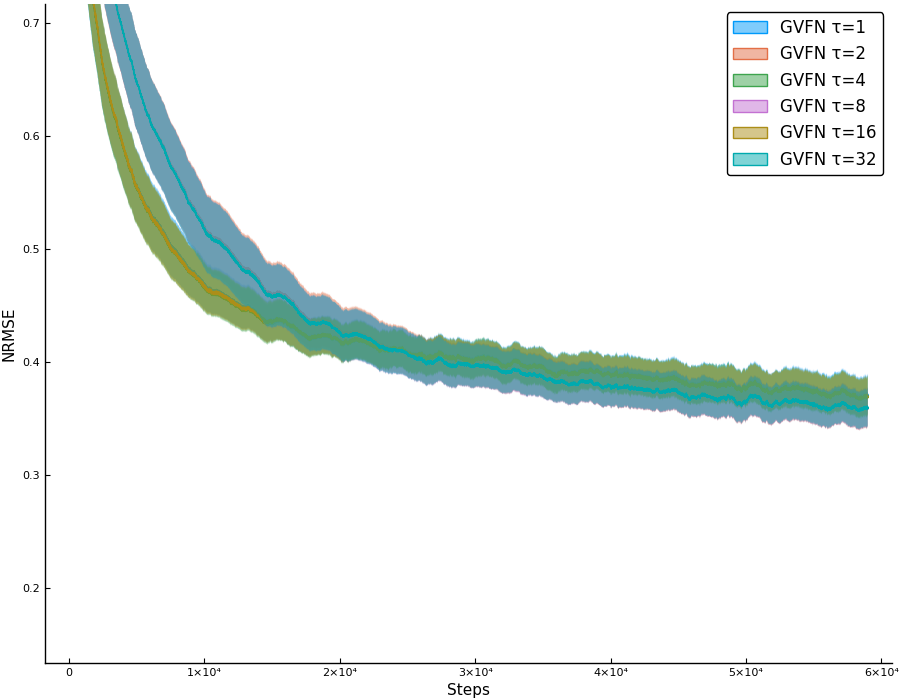

In [42]:
gvfn_ic = ItemCollection(joinpath(data_home,"mackeyglass_gvfn_relu_rmsprop_NRMSE/data"));
p = plot_best_settings(GVFNSpec(gvfn_ic))
plot(p; plot_settings...)

---
# ACEA 
---

In [25]:
RNNSpec(ic; window=1) = PlotSpec(ic, "RNN", "rnn_tau", window)
GVFNSpec(ic; window=1) = PlotSpec(ic, "GVFN", "gvfn_tau", window)

GVFNSpec (generic function with 1 method)

In [26]:
rnn_ic = ItemCollection(joinpath(data_home,"ACEA_rnn/data"))
diff(rnn_ic)

Dict{String,Array} with 4 entries:
  "rnn_tau"     => [1, 2, 4, 8, 16, 32]
  "rnn_lr"      => [0.0001, 0.0005, 0.001, 0.005, 0.01]
  "seed"        => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  "rnn_nhidden" => [32, 64, 128]

In [27]:
p = plot_best_settings(RNNSpec(rnn_ic))
plot(p, size=(900,700)) 

AssertionError: AssertionError: best != Inf

---
# MSO 
---

In [50]:
RNNSpec(ic; window=1) = PlotSpec(ic, "RNN", "rnn_tau", window)
GVFNSpec(ic; window=1) = PlotSpec(ic, "GVFN", "gvfn_tau", window)

plot_settings = [
    #:size=>(900,700),
    :ylim=>[0.4,1.0],
    :grid=>false
]

3-element Array{Pair{Symbol,Any},1}:
 :size => (900, 700) 
 :ylim => [0.15, 0.7]
 :grid => false      

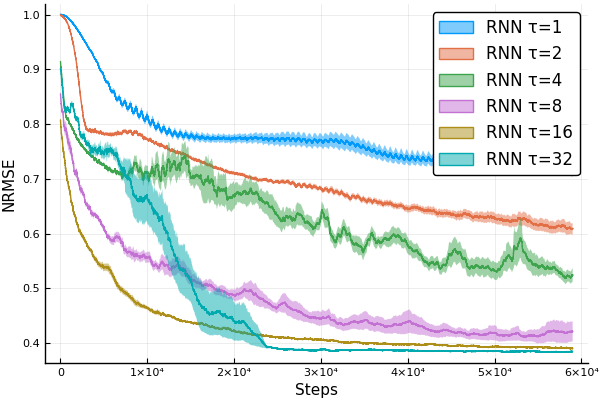

In [52]:
rnn_ic = ItemCollection(joinpath(data_home,"mso_rnn_NRMSE/data"))
p = plot_best_settings(RNNSpec(rnn_ic))
#plot(p; plot_settings...)

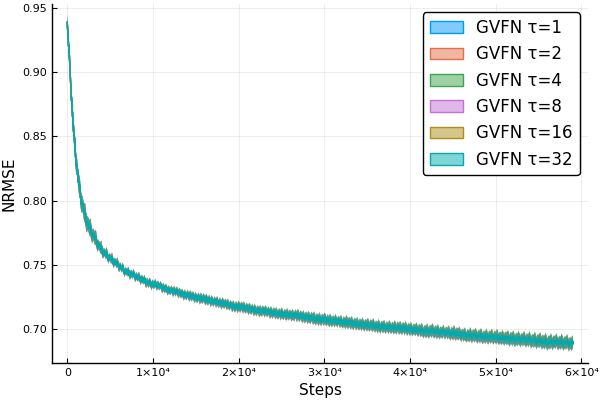

In [54]:
gvfn_ic = ItemCollection(joinpath(data_home,"mso_gvfn_relu_NRMSE/data"))
p = plot_best_settings(GVFNSpec(gvfn_ic))

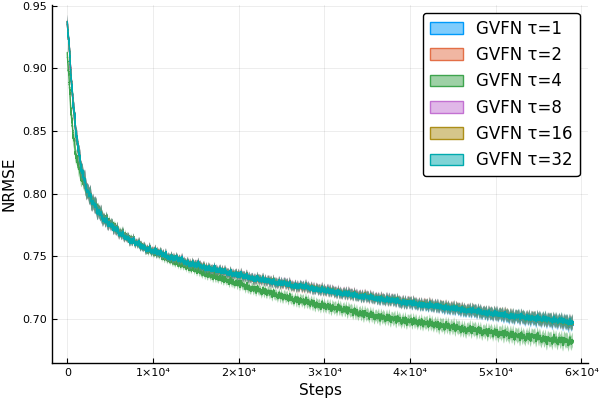

In [55]:
gvfn_ic = ItemCollection(joinpath(data_home,"mso_gvfn_relu_adam_NRMSE/data"))
p = plot_best_settings(GVFNSpec(gvfn_ic))

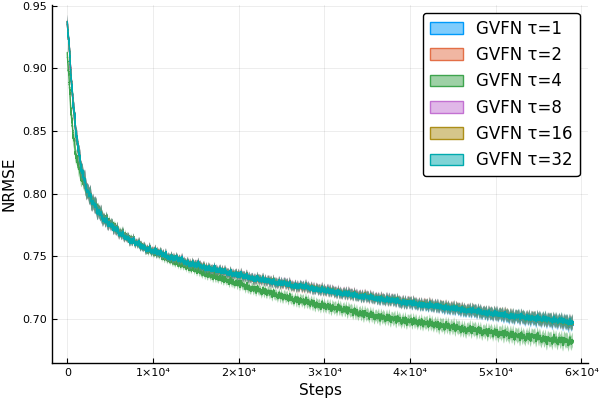

In [56]:
gvfn_ic = ItemCollection(joinpath(data_home,"mso_gvfn_relu_rmsprop_NRMSE/data"))
p = plot_best_settings(GVFNSpec(gvfn_ic))